In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,precision_score,recall_score
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import validation_curve,learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from tensorflow import keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf

In [243]:
df=pd.read_csv('final v3.csv')
df.drop('IMDB ID',inplace=True,axis=1)
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=5,weights='distance')
df=pd.DataFrame(imp.fit_transform(df),index=df.index , columns=df.columns)

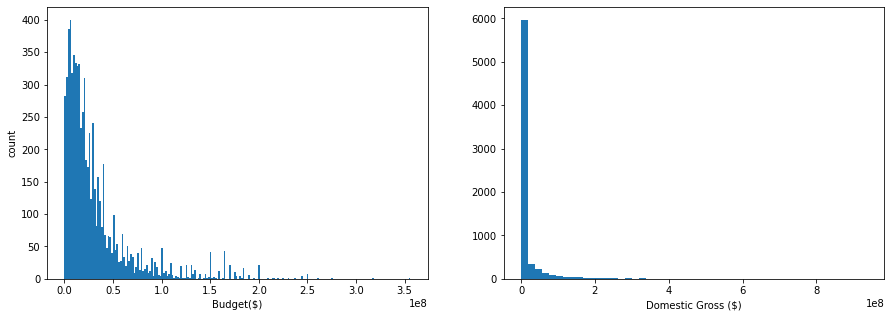

In [244]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].hist(df['Budget'],bins=200)
ax[0].set_xlabel('Budget($)')
ax[1].hist(df['Domestic Gross ($)'],bins=50)
ax[1].set_xlabel('Domestic Gross ($)')

ax[0].set_ylabel('count')
plt.show()

In [245]:
df.head()

,Mojo ID,Year,Opening ($),Budget,Opening Theaters,In Realease (Days),Widest Release,Running time (min),IMDB score,IMDB votes,...,Writer(s) rank,Stars rank,Distributor rank,additive Producer(s) rank,additive Director(s) rank,additive Writer(s) rank,additive Stars rank,additive Distributor rank,Domestic Gross ($),Worldwide Gross ($)
0,8.769715e+08,2011.0,77025481.0,237000000.0,3452.0,379.0,3461.0,162.0,7.8,1122762.0,...,0.0,1.0,1.0,78817892.4,8757543.6,8757543.6,43787718.0,8757543.6,749766139.0,2.744337e+09
1,1.383565e+09,2011.0,110307189.0,200000000.0,4028.0,203.0,4028.0,103.0,8.2,760723.0,...,0.0,1.0,1.0,24951714.4,6237928.6,43665500.2,37427571.6,6237928.6,415004880.0,1.066970e+09
2,3.393226e+09,2011.0,116101023.0,200000000.0,3728.0,302.0,3739.0,108.0,6.4,385498.0,...,0.0,0.0,0.0,24671872.0,2467187.2,4934374.4,14803123.2,2467187.2,334191110.0,1.025467e+09
3,1.515882e+09,2011.0,128122480.0,200000000.0,4380.0,239.0,4390.0,124.0,7.0,726620.0,...,0.0,1.0,1.0,61036080.0,5086340.0,25431700.0,30518040.0,5086340.0,312433331.0,6.239333e+08
4,6.596541e+08,2011.0,64832191.0,68000000.0,4468.0,185.0,4468.0,124.0,5.0,229133.0,...,0.0,0.0,0.0,10310985.0,1145665.0,2291330.0,6873990.0,1145665.0,300531751.0,6.984913e+08


In [246]:
df.isnull().values.any()

False

## classification problem

In [247]:
df=df.drop(['additive Producer(s) rank',
'additive Director(s) rank',
'additive Writer(s) rank',
'additive Stars rank',
'additive Distributor rank','IMDB score','IMDB votes',
'Mojo ID','Opening ($)','In Realease (Days)',
'Widest Release','Metascore','User',
'Critic','Year'],axis=1)


X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)'],axis=1).to_numpy()
Y=df['Domestic Gross ($)'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)


make different classes based on the revenue of the movies 

In [216]:
df=df.reset_index(inplace=False)
dic_classification={}

dic_classification['super hit']=df.loc[(df['Budget']>50e6) & (df['Budget']*4<=df['Worldwide Gross ($)'])].index

dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*4>df['Worldwide Gross ($)']) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

dic_classification['minor success']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5>df['Worldwide Gross ($)']) & (df['Budget']*1.5<=df['Worldwide Gross ($)'])].index

dic_classification['flop']=df.loc[(df['Budget']>50e6) & (df['Budget']*1.5>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

dic_classification['box office bomb'] = df.loc[(df['Budget']>50e6) & (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['hit'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

dic_classification['minor success for mid budget'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['failure'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1>df['Worldwide Gross ($)'])].index

dic_classification['great success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

#dic_classification['big success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

#dic_classification['success'] = df.loc[(df['Budget']<=1e6)  &  (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) ].index


In [280]:
df=df.reset_index()
dic_classification={}

dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

#dic_classification['blockbuster']=df.loc[(df['Budget']>50e6) & (df['Budget']*4>df['Worldwide Gross ($)']) & (df['Budget']*2.5<=df['Worldwide Gross ($)'])].index

dic_classification['minor success']=df.loc[(df['Budget']>50e6) & (df['Budget']*2.5>df['Worldwide Gross ($)']) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['flop']=df.loc[(df['Budget']>50e6) & (df['Budget']*1>df['Worldwide Gross ($)']) ].index

#dic_classification['box office bomb'] = df.loc[(df['Budget']>50e6) & (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['hit'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1<=df['Worldwide Gross ($)'])].index

dic_classification['terrible'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*1>df['Worldwide Gross ($)']) & (df['Budget']*0.1<=df['Worldwide Gross ($)'])].index

dic_classification['failure'] = df.loc[(df['Budget']<=50e6) & (df['Budget']>1e6) & (df['Budget']*0.1>df['Worldwide Gross ($)'])].index

dic_classification['great success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2<=df['Worldwide Gross ($)'])].index

#dic_classification['big success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) & (df['Budget']<=df['Worldwide Gross ($)'])].index

#dic_classification['success'] = df.loc[(df['Budget']<=1e6)  &  (df['Budget']>df['Worldwide Gross ($)'])].index

dic_classification['success'] = df.loc[(df['Budget']<=1e6)  & (df['Budget']*2>df['Worldwide Gross ($)']) ].index


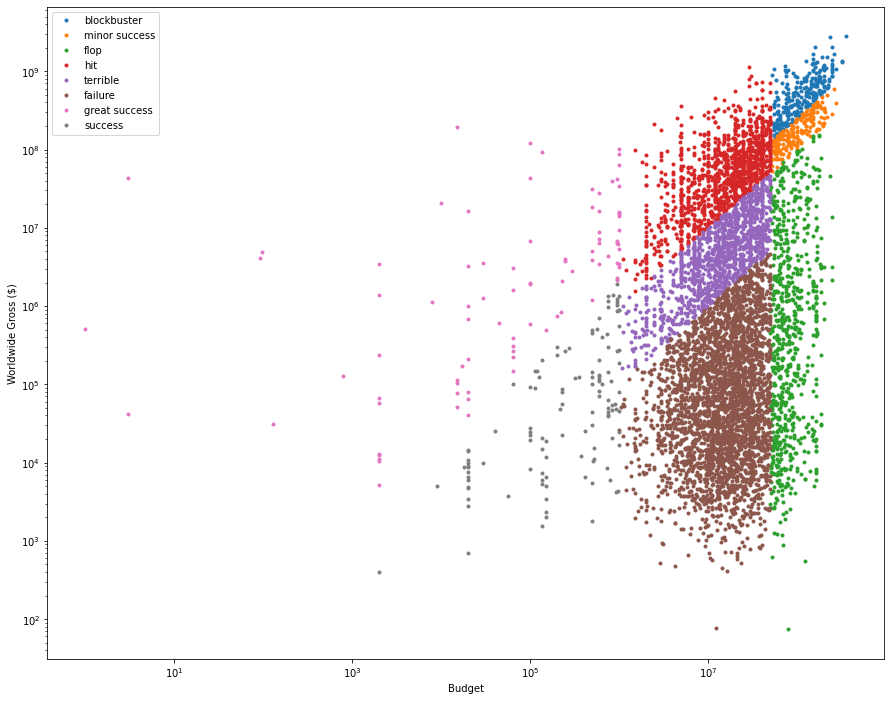

In [282]:
plt.figure(figsize=(15,12))
for key in dic_classification.keys():
    plt.plot(df.loc[dic_classification[key]]['Budget'],df.loc[dic_classification[key]]['Worldwide Gross ($)'],'.',label=key)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Budget ($)')
plt.ylabel('Worldwide Gross ($)')
plt.show()

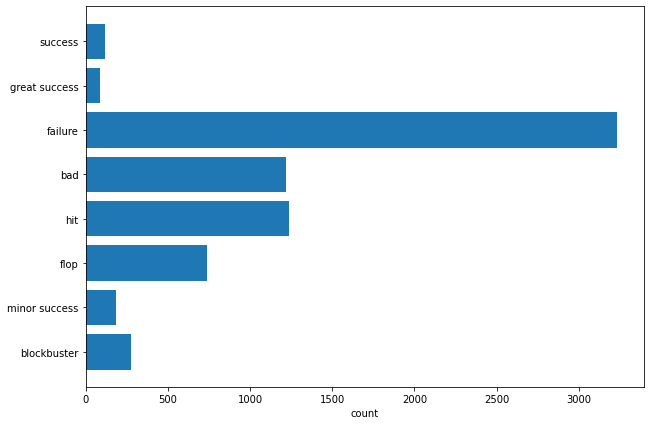

In [250]:
plt.figure(figsize=(10,7))
heights=[len(dic_classification[key]) for key in dic_classification.keys()]
plt.barh(list(dic_classification.keys()),heights)
plt.xlabel('count')
plt.show()

In [251]:
v=0
for key in dic_classification.keys():
    print(key,len(dic_classification[key]))
    v+=len(dic_classification[key])
print(v)

blockbuster 275
minor success 188
flop 737
hit 1238
bad 1217
failure 3232
great success 89
success 120
7096


In [252]:
label={key:i for i,key in enumerate(dic_classification.keys())}
for key in dic_classification.keys():
    df.loc[dic_classification[key],'class'] = int(label[key])

In [253]:
label

{'blockbuster': 0,
 'minor success': 1,
 'flop': 2,
 'hit': 3,
 'bad': 4,
 'failure': 5,
 'great success': 6,
 'success': 7}

In [254]:
X=df.drop(['Domestic Gross ($)','Worldwide Gross ($)','class'],axis=1).to_numpy()
Y=df['class'].to_numpy()
scaler=MinMaxScaler()
X=scaler.fit_transform(X)
X,Y=shuffle(X,Y)

In [255]:
print(f'X: {X.shape} \nY: {Y.shape}')

X: (7096, 276) 
Y: (7096,)


In [256]:
Y_oh = ks.utils.to_categorical(Y, num_classes=len(set(Y)), dtype=int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_oh, random_state=0)

In [271]:
import kerastuner as kt

def model_builder(hp):
    model = Sequential()
    #model.add(ks.layers.Flatten(input_shape=(1,11)))

    hp_units = hp.Int('units1', min_value=5, max_value=100, step=5)
    model.add(ks.layers.Dense(units=hp_units, input_dim=276,
                               activation='relu', 
                               kernel_regularizer=ks.regularizers.l2(.05)))

    
    hp_units2 = hp.Int('units2', min_value=5, max_value=100, step=5)
    model.add(Dense(units=hp_units2, activation='tanh',kernel_regularizer=ks.regularizers.l2(.05)))
    model.add(Dense(len(set(Y)), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=ks.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [272]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=os.path.normpath('C:/'),
                     project_name='nn_class_v3')

In [273]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [274]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and for second layers is {best_hps.get('units2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.5821596384048462

Best val_accuracy So Far: 0.5924882888793945
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 10 and for second layers is 85 and the optimal learning rate for the optimizer
is 0.01.



In [276]:
%%time
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=200, validation_split=0.2,verbose=0)



Wall time: 25 s


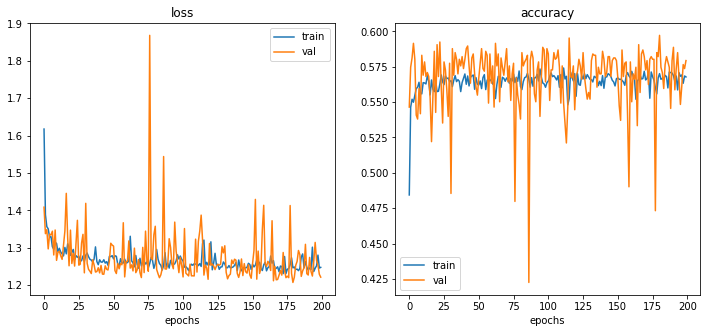

In [277]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[0].legend(['train','val'])
ax[1].legend(['train','val'])

ax[0].set_title('loss')
ax[1].set_title('accuracy')

ax[0].set_xlabel('epochs')
ax[1].set_xlabel('epochs')
plt.show()

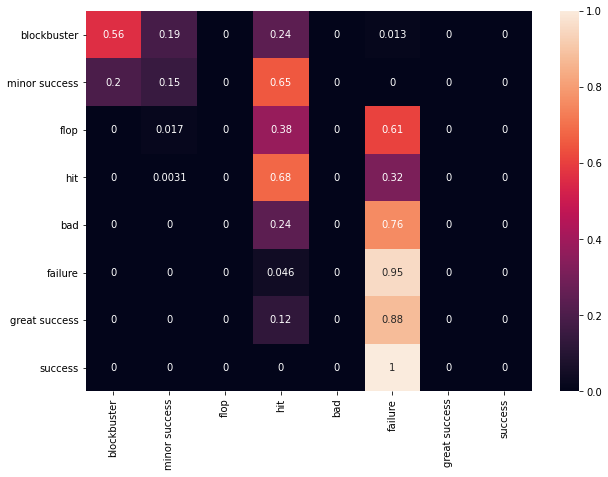

In [278]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

Y_predicted = np.argmax( model.predict(X_test) , axis=1 )
cm = confusion_matrix(np.argmax( Y_test , axis=1 ), Y_predicted)
vector = cm.sum(axis=1)

cm = cm / vector[:,None]
df_cm = pd.DataFrame(cm, index = [key for key in dic_classification.keys()],
                  columns = [key for key in dic_classification.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.show()

In [279]:
y_pred=np.argmax( model.predict(X_test) , axis=1 )
print(f'The precision score for each class is {precision_score(np.argmax(Y_test,axis=1),y_pred,average= None,zero_division=True)}')


The precision score for each class is [0.82352941 0.28       1.         0.49099099 1.         0.61244019
 1.         1.        ]
